![img](utils/usak.webp)

# ¿Es determinante el entorno  para los asesinos en serie?
##### Memoria del proyecto

## Índice
1. [Introducción](#INTRODUCCION)
2. [Hipótesis](#HIPOTESIS)
3. [Limpieza de datos](#LIMPIEZA-DE-DATOS)
4. [Análisis de los datos y comprobación de hipótesis](#ANALISIS-DE-DATOS-Y-COMPROBACION-DE-HIPOTESIS)
    
    4.1. [Países en los que están más presentes o cometen más crímenes](#HIPOTESIS-1)

    4.2. [Clase socioeconómica](#HIPOTESIS-2)

    4.3. [Densidad de población](#HIPOTESIS-3)

    4.4. [¿Realmente son más comunes en América y Europa?](#HIPOTESIS-4)

    4.5. [¿En qué países les descubren antes?](#HIPOTESIS-5)
5. [Visualización de los datos](#VISUALIZACIONES)
6. [Conclusiones y consideraciones](#CONCLUSIONES)

## INTRODUCCION
Un asesino en serie no comete crímenes pasionales, ni suele elegir a sus víctimas por rencor ni para ajustar cuentas. De hecho, puede llegar a ser metódico y tener templanza.
Entonces, ¿cómo surge este perfil de asesino? ¿Qué factores los motiva a actuar?

Este análisis de datos exploratorio se centrará en el estudio de múltiples asesinos en serie para determinar patrones que puedan desencadenar sus conductas. Sobre todo, los factores en los que se centrará son:

+ País de procedencia
+ Número de víctimas
+ Densidad de población
+ Índice de pobreza

#### Fuentes de datos

Para este proyecto he utilizado [cuatro datasets de Kaggle](https://www.kaggle.com/datasets/vesuvius13/serial-killers-dataset/data), separados según el número de víctimas de los asesinos, un [JSON de la densidad de población de cada país](https://data.world/samayo/country-names/workspace/file?filename=country-population-density.json), el [índice de pobreza de cada país según OECD Data](https://data.oecd.org/inequality/poverty-rate.htm) y, por último, una [clave de códigos ISO y nombres de países](https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv).

Con los datos recopilados, dispongo de información de 355 asesinos, 6292 víctimas, 57 países, 5 continentes y datos que van de 1900 a 2018.

## HIPOTESIS
1. ¿Hay ciertos **países** en los que estos asesinos están más presentes o donde cometen más crímenes?

2. Suelen pertenecer a **clases socioeconómicas bajas** o es lo que predomina a su alrededor

3. Ese tipo de perfil de asesino tiende a aparecer en lugares con **alta densidad de población**

4. En las series siempre se habla de los casos de estadounidenses, pero ¿realmente son más comunes en **América y Europa** o es solo que en los otros continentes no se estudian estos casos o no se publica esta información?
(Claramente partimos del sesgo de nuestra cultura occidental y del peso que tiene EE.UU. en esta).

5. ¿En qué países les descubren o capturan antes?

## LIMPIEZA DE DATOS

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
hivict = pd.read_csv("data\\Highest_victim_count.csv") #highest victim count
popdens = pd.read_json("data\\country-population-density.json") #population density
povrates = pd.read_csv('data\\spoverty_rate.csv') #poverty rate
mainvict = pd.read_csv("data\\15_to_30_victim_count.csv") #main, 15-30 victim count
less5vict=pd.read_csv("data\\Lessthan_5_victim_count.csv")
fr5to14vict=pd.read_csv("data\\5_to_14_victim_count.csv")
countrycode=pd.read_csv("data\\iso_countrycode.csv")

In [ ]:
# homogeneizar nombres de columnas
for df in hivict,mainvict,less5vict,fr5to14vict:
    for col in df:
        df.rename(columns={col:col.lower()}, inplace=True)

#### Limpieza de los cuatro datasets de los sujetos
(Este proceso desarrollado se encuentra en el *notebook* [1datacleaning.ipynb](\\notebooks\\1datacleaning.ipynb).)

+ El primer paso, y el más laborioso, fue el de limpiar los datos.
+ La columna de países de procedencia de los sujetos incluía varios valores en la misma celda (además de datos como "Brasil (supuestamente)"), por lo que he tenido que limpiarla separando los valores en una lista (```str.split()```) y dividiéndolos en filas con ``` pd.explode()```. De esta forma, si un sujeto perpetró crímenes en tres países, aparecerá tres veces, ya que lo que nos importa realmente son los países en los que tienen lugar dichos crímenes.

In [ ]:
#separating countries in the same cell as a list
hivict['country']=hivict['country'].str.split('\r\n')

#dividing list in several rows and removing the " (alleged)" bit
hivictexp=hivict.explode('country')
hivictexp['country']=hivictexp['country'].str.replace(" (alleged)","") #same for "(suspected),(claimed)"
hivictexp['country'].unique()

Este proceso se repite para las cuatro tablas de datos de asesinos, que posteriormente se concatenarán.

#### Limpieza de los datasets de datos demográficos y la clave de país-código ISO

(Este proceso desarrollado se encuentra en el notebook [1datacleaning.ipynb](\\notebooks\\1datacleaning.ipynb).)

+ Lo primero que tuve que hacer fue homogeinizar los nombres de las columnas y eliminar las que eran irrelevantes:

In [7]:
povrates.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,POVERTY,TOT,RT,A,2018,0.124,NaN
1,AUS,POVERTY,TOT,RT,A,2020,0.126,NaN
2,AUT,POVERTY,TOT,RT,A,2018,0.094,NaN
3,AUT,POVERTY,TOT,RT,A,2019,0.100,NaN
4,AUT,POVERTY,TOT,RT,A,2020,0.096,NaN


In [ ]:
# homogeneizar nombres de columnas
for col in povrates:
    povrates.rename(columns={col:col.lower()}, inplace=True)

povrates.rename(columns={'location':'code', 'time':'year'}, inplace=True)

povrates=povrates[['code', 'year','value']]
povrates.head()

+ Principalmente quería basarme en dos datos demográficos: **la densidad de población y el índice de pobreza**.Sin embargo, el dataset de *poverty rates* incluía el código ISO de los países en lugar de su nombre, lo que me obligó a buscar otro csv que me permitiera hacer la correspondencia entre ambos.


In [ ]:
countrycode=countrycode[['English short name lower case', 'Alpha-3 code']]
countrycode.rename(columns={'English short name lower case':'country name', 'Alpha-3 code': 'code'},inplace=True)
countrycode.sort_values(['code'])

+ Después tuve que limpiar el dataset de índice de pobreza, que tenía varios valores según el año, pero muchos NaN también. **Decidí agruparlos por país y hacer una media del índice de pobreza, para dejar solo una fila por país, que después sería una nueva columna del dataframe.**

In [ ]:
avgpovratecountry=povrates.groupby('code')['value'].mean()
avgpovratecountry=pd.DataFrame(avgpovratecountry).reset_index()
avgpovratecountry.rename(columns={'value':'mean value'},inplace=True)
avgpovratecountry.drop(columns=['level_0','index'],inplace=True)

+ Una vez hecho esto, se podía eliminar la columna de año y los valores nulos.

In [ ]:
povrates.dropna(subset=['value'],inplace=True)
povrates.dropna(subset=['year'],inplace=True)
simplepovrates=povrates.drop(columns='year').drop_duplicates('code')

+ A partir de ahí, tuve que empezar a utilizar ```pd.merge()``` para juntar los datos demográficos y la clave de país-código ISO.

In [ ]:
cleanpovrate=simplepovrates.merge(avgpovratecountry, on='code').drop(columns='value')

+ Se añade el nombre de los países a *pov rates* haciendo un merge con la anterior tabla.

In [ ]:
countrypovrate=pd.merge(cleanpovrate, countrycode, how='outer')
countrypovrate.dropna(subset=['mean value'],inplace=True)

#### Homogeinizar los nombres de los países en los distintos datasets


+ **Ahí me di cuenta de que algunos países del dataset de asesinos no estaban escritos igual que los de este dataset** (por ejemplo, 'Korea, Republic of', frente a 'South Korea').
+ Esto me obligó a crear un diccionario para corregir y homogeninizar los nombres de los países:

In [ ]:
wrongpovratecountries={'Korea, Republic of':'South Korea'}

for wrong,right in wrongpovratecountries.items():
    countrypovrate['country name']=countrypovrate['country name'].str.replace(wrong, right)

+ El mismo procedimiento se repitió para el dataest de la densidad de población:

In [ ]:
wrongpopdenscountries={'Iran, Islamic Rep.':'Iran','Russian Federation':'Russia','Korea, Rep.':'South Korea',
                       'Venezuela, RB':'Venezuela','Yemen, Rep.':'Yemen'}

for wrong,right in wrongpovratecountries.items():
    popdens['country']=popdens['country'].str.replace(wrong, right)

In [12]:
exphivict = pd.read_csv("data\\provisional_csv\\exp_highest_victim.csv") #highest victim count
exp30vict = pd.read_csv("data\\provisional_csv\\exp15_30_victim.csv") #main, 15-30 victim count
exp5vict=pd.read_csv("data\\provisional_csv\\exp_less5_victim.csv")
exp14vict=pd.read_csv("data\\provisional_csv\\exp5_14_victim.csv")
killers = pd.read_csv("data\\provisional_csv\\clean_totalvict.csv",index_col=0) #killer data
popdens = pd.read_csv("data\\provisional_csv\\cleanpopdens.csv",index_col=0) #population density
povrate = pd.read_csv('data\\provisional_csv\\cleancountrypovrate.csv',index_col=0) #poverty rate

(Este proceso desarrollado se encuentra en el notebook [2datacleaning_matching.ipynb](\\notebooks\\2datacleaning_matching.ipynb).)

+ Se concatenan los cuatro datasets de datos de asesinos con ```pd.concat()``` y se ve los países cuyo nombre no encaja con los otros datasets (para hacer otro diccionario).

In [ ]:
totalvict=pd.concat([exphivict,exp30vict,exp14vict,exp5vict],axis=0,ignore_index=True)
totalvict=totalvict.drop(columns='Unnamed: 0')
#keys are wrong, values are the correct ones (in killer df)
wrongkillercountries={'Allied-occupied Germany':'Germany','Austria-Hungary':'Hungary',
                      'Czechoslovakia':'Czech Republic','East Germany':'Germany','German Empire':'Germany',
                      'Kingdom of Romania':'Romania','Ottoman Empire':'Iran','Portuguese Angola':'Angola',
                      'West Germany':'Germany', 'Soviet Union':'Ukraine', 'Yugoslavia':'Serbia'}

for wrong,right in wrongkillercountries.items():
    totalvict['country']=totalvict['country'].str.replace(wrong, right)

(Este proceso desarrollado se encuentra en el *notebook* [3mergingdf.ipynb](\\notebooks\\3mergingdf.ipynb).)

+ Por último, en un último Jupyter notebook de limpieza se fusionan todos los datasets para poder trabajar con un dataframe definitivo y se eliminan las columnas innecesarias.

In [ ]:
povrate['country']=[pov.strip() for pov in povrate['country']]

#merged killers df with poverty rate df
kill_povrate=killers.merge(povrate, how='left')

kill_povrate['mean value'].isnull().value_counts() #quite a few nans for poverty rate

#remove "code" column
kill_povrate.drop(columns='code', inplace=True)

In [ ]:
#merged killers_povrate df with pop density df
dfkillers=kill_povrate.merge(popdens, how='left')
dfkillers.rename(columns={'mean value':'pov rate'},inplace=True)

# dfkillers.to_csv("..\\data\\cleaned\\eda_df.csv")

In [ ]:
popdens['country']=[dens.strip() for dens in popdens['country']]

+ El *eda_df* ya casi está listo para el análisis. Veamos el resultado:

In [ ]:
len(dfkillers[(dfkillers['density'].notnull()) & (dfkillers['pov rate'].notnull())])
#201 killers with both data
#pov rate: 205 values, 150 nan
#density: 313 values, 42 nan

+ Hay 150 países sin datos de índice de pobreza y 42 países sin datos de densidad de población. **Es decir, disponemos de todos los datos de 201 sujetos**.
+ Se exporta otro csv sin NaN también:

In [ ]:
notnullkillers=dfkillers[(dfkillers['density'].notnull()) & (dfkillers['pov rate'].notnull())]
# notnullkillers.to_csv("..\\data\\cleaned\\notnull_df.csv")

### Cambio del tipo de los valores del df (de str a int/float)

In [13]:
# dfkillers.info

(Este proceso desarrollado se encuentra en el notebook [4converttypes.ipynb](\\notebooks\\4converttypes.ipynb).)

Los valores de la tabla son *object* aun siendo numéricos, por lo que hay que transformarlos.

Sin embargo, hay otros caracteres en la celda, como "11-16" o "203,456.000", por lo que hay que limpiarlos con ```split()``` y ```replace()```:

In [ ]:
df[df['proven victims'].str.contains('–')]

+ Conservamos solamente el primer número de víctimas [0], es más seguro que el segundo (que es una cifra sin confirmar)

In [ ]:
df['proven victims']=df['proven victims'].str.split('–').str[0]
#conservamos solamente el primer número de víctimas [0], es más seguro que el segundo (sin confirmar)

+ Eliminamos las comas de los millares

In [ ]:
df['density']=df['density'].str.replace(",","")

+ Ya se puede transformar los datos a int o float, según corresponda

In [ ]:
df['proven victims']=df['proven victims'].astype(int)
df['pov rate']=df['pov rate'].astype(float)
df['density']=df['density'].astype(float)

## ANALISIS DE DATOS Y COMPROBACION DE HIPOTESIS

(Este proceso desarrollado se encuentra en el *notebook* [5stats.ipynb](\\notebooks\\5stats.ipynb).)
+ Creación de nuevas series y dataframes a partir de los datos
+ Obtención de datos estadísticos básicos por columnas (```mean(), max(), median(), min(), mode(),describe(include='all')```)

+ Obtención del número de asesinos que hay en cada país para que el análisis sea más exacto

In [ ]:
df['country'].value_counts(ascending=False)
#box plot with quartiles

+ Se crea un nuevo dataframe con esta información, que luego uniremos al df principal con ```merge()```.

In [ ]:
#Nº DE ASESINOS POR PAÍS
killerspercountry=df.groupby('country')['name'].count().sort_values(ascending=False).reset_index()
killerspercountry.rename(columns={'name':'amount'},inplace=True)

In [ ]:
killerspercountry['amount'].agg(['median','mean','max','min'])
#98 es un outlier q descompensa la media

+ Se une la nueva columna de asesinos por país al df principal con ```merge()```.

In [ ]:
dfamount=df.merge(killerspercountry,on='country',how='left')
dfamount.head()

In [ ]:
#pov rate and country based on number of victims
dfamount.groupby('proven victims')[['pov rate','country','amount']].agg({'pov rate':['mean','max','min'],'amount':['mean','max','min'],'country': 'first'}).reset_index().sort_values(by=('proven victims'),ascending=False)

In [ ]:
killerspercountrypovrdens=dfamount.groupby('country')[['density','pov rate','amount']].agg({'density':'first','pov rate':'first','amount':'first'}).round(2).sort_values(by='amount', ascending=False).reset_index()
killerspercountrypovrdens
#this shows the amount of killers per country related to its density and pov rate (and victims)

+ Se repite este mismo proceso para calcular el número total de víctimas de cada país:

In [ ]:
#calculate the number of victims per country
victimspercountry=df.groupby('country')['proven victims'].sum().sort_values(ascending=False).reset_index()
victimspercountry.rename(columns={'proven victims':'country victims'},inplace=True)
df=df.merge(victimspercountry,on='country', how='inner')

### HIPOTESIS 1
+ En que países hay más asesinos en serie y víctimas

In [ ]:
#pov rate and country based on number of victims
df.groupby('proven victims')[['pov rate','country']].agg({'pov rate':['mean','max','min'],'country': 'first'}).reset_index().sort_values(by=('proven victims'),ascending=False)

In [33]:
maxvicpercountry=df.groupby('country')['proven victims'].max().sort_values(ascending=False)
maxvicpercountry

country
Venezuela         138
Colombia          138
Ecuador           138
Peru              110
Pakistan          100
Russia             83
Brazil             72
India              70
China              67
United States      60
Italy              58
Ukraine            53
Canada             49
Indonesia          42
South Africa       38
Morocco            36
Hungary            35
Romania            35
Serbia             35
Mexico             33
Iran               33
Iraq               33
Egypt              32
Germany            30
Swaziland          28
Greece             27
United Kingdom     26
France             23
Switzerland        23
Tajikistan         22
South Korea        21
Afghanistan        20
Costa Rica         19
Latvia             19
Turkey             18
Belgium            16
Spain              16
Argentina          15
Poland             14
Chile              14
Tunisia            13
Thailand           12
Malaysia           12
Japan              12
Nepal              12
Ye

In [ ]:
df.groupby('country')['proven victims'].mean().round(2).sort_values(ascending=False)


In [ ]:
df.groupby('country')['proven victims'].sum().idxmax()#.sort_values(ascending=False)

In [ ]:
df['country'].mode()

0    United States
Name: country, dtype: object

Garavito es un outlier, descompensa los datos de Colombia y Venezuela

> Parece que en países latinoamericanos hay más asesinatos de media y también de mayor número por asesino (asesinos más 'prolíficos').
>
> Sin embargo, el país donde más asesinos ha habido es EE.UU (y si se suman todos los asesinos por país, es el país donde más crímenes se han cometido).

In [ ]:
victimstats=df.groupby('country')['proven victims'].agg(['median','mean','max','min']).round(1).sort_values(by='median', ascending=False)
victimstats.reset_index(inplace=True)

### HIPOTESIS 2
2. Clases socioeconómicas bajas

In [ ]:
df['country'][df['pov rate'].idxmax()] #costa rica tiene el mayor poverty rate (de los q hay info)
df['country'][df['pov rate'].idxmin()] #Rep Checa tiene el menor poverty rate (de los q hay info)df['country'][df['pov rate']>df['pov rate'].median()].unique()
df['country'][df['pov rate']>df['pov rate'].median()].unique()
df['country'][df['pov rate']<df['pov rate'].median()].unique()
#países con un pov rate por encima y debajo de la mediana del dataset

In [ ]:
#pov rate and country based on number of victims
df.groupby('proven victims')[['pov rate','country']].agg({'pov rate':['mean','max','min'],'country': 'first'}).reset_index().sort_values(by=('proven victims'),ascending=False)

### HIPOTESIS 3
1. Países con alta densidad de población

In [ ]:
#higher density countries vs victims
df[df['density']> df['density'].mean()].sort_values(by='proven victims',ascending=False)

In [ ]:
victimdensitycountry=df.groupby(['proven victims','country'])['density'].agg(['first']).round(2).sort_values(by='first', ascending=False).reset_index()
victimdensitycountry
# victimsdensity

Repetimos este último df teniendo en cuenta el número de asesinos que hay en cada país:

In [ ]:
#pov rate and country based on number of victims
dfamount.groupby('proven victims')[['pov rate','country','amount']].agg({'pov rate':['mean','max','min'],'amount':['mean','max','min'],'country': 'first'}).reset_index().sort_values(by=('proven victims'),ascending=False)

In [14]:
# dfamount['density'].median()

In [ ]:
killerspercountrypovrdens=dfamount.groupby('country')[['density','pov rate','amount']].agg({'density':'first','pov rate':'first','amount':'first'}).round(2).sort_values(by='amount', ascending=False).reset_index()
killerspercountrypovrdens
#this shows the amount of killers per country related to its density and pov rate (and victims)

+ El df creado arriba muestra la densidad media, máxima y mínima según el país y el número de víctimas.
Con él, se desmiente mi primera hipótesis, parece que la densidad de población no hace que los asesinos sean más 'prolíficos', aunque sí que están presentes en esos lugares.

+ Aun así, lugares como Rusia tienen una baja densidad de población a nivel de país, pero probablemente las ciudades concretas donde actuaron tuvieran un valor mayor.

### HIPOTESIS 4
¿Realmente son más comunes en América y Europa?

In [ ]:
(df['country']== 'United States').value_counts() #98 from USA out of 355
#pie chart
df['country'].value_counts(ascending=False)
#box plot with quartiles

>Parece que, efectivamente, en Europa y el norte de Asia hay muchos más casos, mientras que, al menos documentados, hay muy poco en países como Egipto o Yemen.
>
>Sí que sorprende la predominancia de Rusia frente a todo menos EE.UU., que se lleva la palma clarísimamente.
>
>Países como Colombia o Venezuela, que tenían una de las mayores medias de asesinatos, parecen deberse a una sola persona o pocas de ellas, no a múltiples asesinos.


> Habrá que hacer un scatter plot para diferenciar si un país tiene muchos asesinatos y pocos asesinos o viceversa (como Colombia con Luis Garavito (outlier))

### HIPOTESIS 5
+ En que países los descubren o capturan antes (según el número de víctimas que "alcanzaron").

In [ ]:
#When do they get caught?
df.groupby('country')['proven victims'].max().sort_values(ascending=False)

# VISUALIZACIONES

(Este proceso desarrollado se encuentra en el *notebook* [6visuals.ipynb](\\notebooks\\6visuals.ipynb).)
+ A continuación se tratará de comprobar o refutar las hipótesis planteadas por medio de gráficas que respalden los datos.

In [15]:
df = pd.read_csv("data\\cleaned\\eda_df_victimpercountry.csv",index_col=0)

In [17]:
# df.head()

### HIPOTESIS 1.
¿En qué países cometen más asesinatos o hay más asesinos en serie?

In [ ]:
killerspercountry=df.groupby('country')['name'].count().sort_values(ascending=False).reset_index()

+ Haré un bar plot para comparar la cantidad de asesinos por país. (Descartaré los países con menos de dos asesinos para no saturar el eje de la gráfica).

<Figure size 600x1000 with 0 Axes>

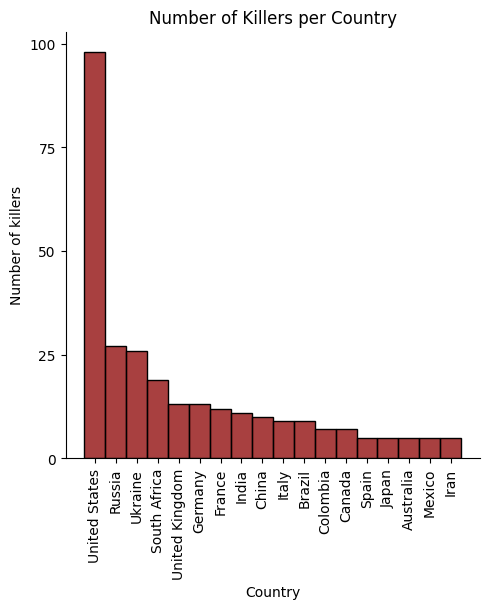

In [26]:
#HISTOGRAMA
distplot4=df[['country','amount']][df['amount']>4].sort_values(by='amount',ascending=False)

plt.figure(figsize=(6,10));
sns.displot(distplot4['country'],color='darkred');
plt.axis('tight');
plt.xticks(rotation=90);
plt.xlabel('Country');
plt.ylabel('Number of killers');
plt.title('Number of Killers per Country');
plt.yticks(range(0,101,25));

Ya sabemos que en EE.UU. están la mayoría, por lo que nos acercaremos a los demás para verlos con más detalle.

<Figure size 500x900 with 0 Axes>

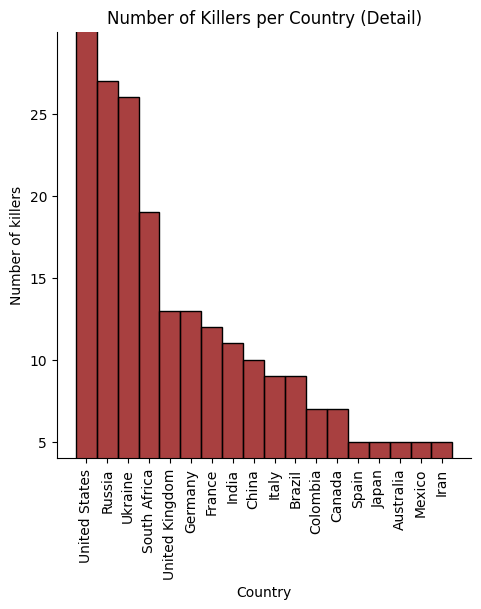

In [27]:
#repeat zooming in
plt.figure(figsize=(5,9))
sns.displot(distplot4['country'],color='darkred')
plt.axis('tight')
plt.xticks(rotation=90);
plt.ylim(4,30)
plt.yticks(range(5,30,5))

plt.xlabel('Country');
plt.ylabel('Number of killers');
plt.title('Number of Killers per Country (Detail)');

A lo largo del análisis me surgió la duda de **si en ciertos países había muchas víctimas porque había muchos asesinos o porque había un asesino más "prolífico" o activo**.

Por ello, decidí hacer un boxplot para identificar estos valores y posibles outliers.

Text(33.347222222222214, 0.5, 'Number of victims')

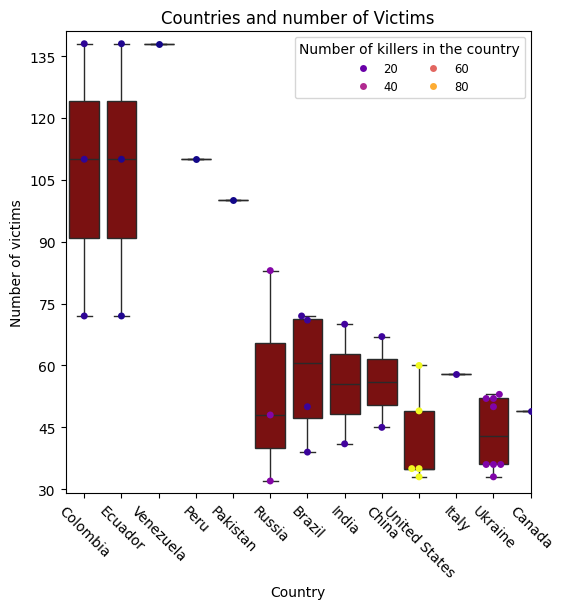

In [56]:
#repetir boxplot con countries > x
plt.figure(figsize=(6,6))
sns.boxplot(data=(df[df['proven victims']>30].sort_values(by='proven victims',ascending=False)), x='country',y='proven victims',color='darkred');
sns.swarmplot(data=(df[df['proven victims']>30].sort_values(by='proven victims',ascending=False)), x='country',y='proven victims', hue='amount',palette='plasma');
plt.xticks(rotation=-45);

legend = plt.legend(title="Number of killers in the country", #fontsize=8,
                    loc='upper right', fontsize='small', fancybox=True,ncol=2)

# plt.legend(loc = 'upper right', frameon = False, ncol = 2)
# plt.legend.set_title('Number of killers in the country')

plt.ylim(29,141)
plt.xlim(-0.5,'Canada')
plt.yticks(range(30,141,15))
plt.title('Countries and number of Victims')
plt.xlabel('Country')
plt.ylabel('Number of victims')

In [ ]:
df['amount'].agg(['median','mean','max','min'])
#98 (USA) es un outlier q descompensa la media

df[df['proven victims']>30].sort_values(by='proven victims',ascending=False)

Dado que EE.UU. destaca tanto como Colombia y Ecuador por la disparidad de sus valores, los representaré aislados en un violinplot para comprender mejor esta casuística.

In [ ]:
outliers=df[(df['country']=='United States')|(df['country']=='Colombia')]
outliers

Text(55.597222222222214, 0.5, 'Number of victims')

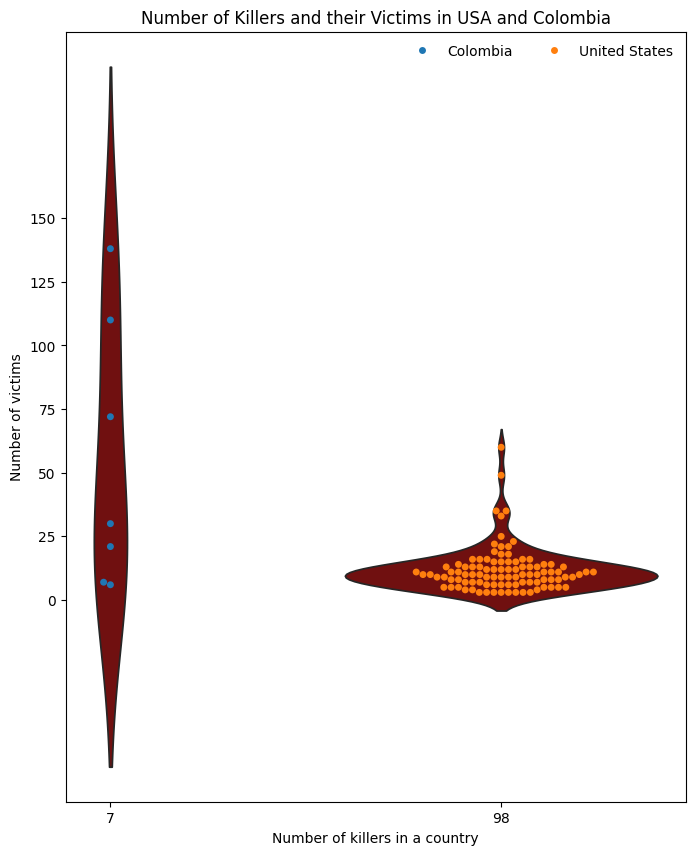

In [52]:
plt.figure(figsize=(8,10))
sns.violinplot(data=(outliers.sort_values(by='proven victims',ascending=False)), x='amount',y='proven victims',color='maroon',inner=None);
sns.swarmplot(data=(outliers.sort_values(by='proven victims',ascending=False)), x='amount',y='proven victims', hue='country');#, color='lightgray');
# plt.xticks(rotation=90);
plt.legend(loc = 'upper right', frameon = False, ncol = 2)
plt.ylim(-60,220)
plt.yticks(range(0,151,25))
plt.axis('tight')
# plt.yticks(range(30,141,15))
plt.title('Number of Killers and their Victims in USA and Colombia')
plt.xlabel('Number of killers in a country')
plt.ylabel('Number of victims')

+ Haré también un scatterplot para que quede más clara esta distribución dispar. 

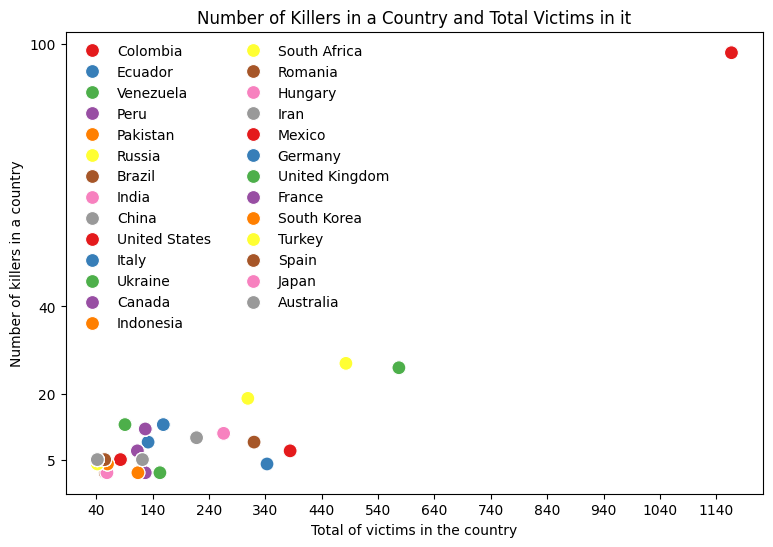

In [53]:
plt.figure(figsize=(9,6))
sns.scatterplot(data=df[df['country victims']>40],#.sort_values(by='country',ascending=True),
                x='country victims',
                y='amount',
                hue = 'country',
                palette='Set1',
                s=100);
# plt.ylim(0,100)
plt.yticks([5,20,40,100])
plt.xticks(range(40,1200,100))

plt.title('Number of Killers in a Country and Total Victims in it')
plt.ylabel('Number of killers in a country')
plt.xlabel('Total of victims in the country')
plt.legend(loc = 'upper left', frameon = False, ncol = 2)

+ Como se puede apreciar, hay países como EE.UU. con un gran número de asesinos, pero menos víctimas por asesino.

+ Por otro lado hay asesinos particularmente "prolífico" que hacen que en países como Colombia o Venezuela con tan solo dos asesinos haya un mayor número de víctimas.

+ Otra muestra de la distribución dispar, EE.UU. está completamente apartado del resto de valores:

Text(0.5, 36.72222222222221, 'Total of victims in the country')

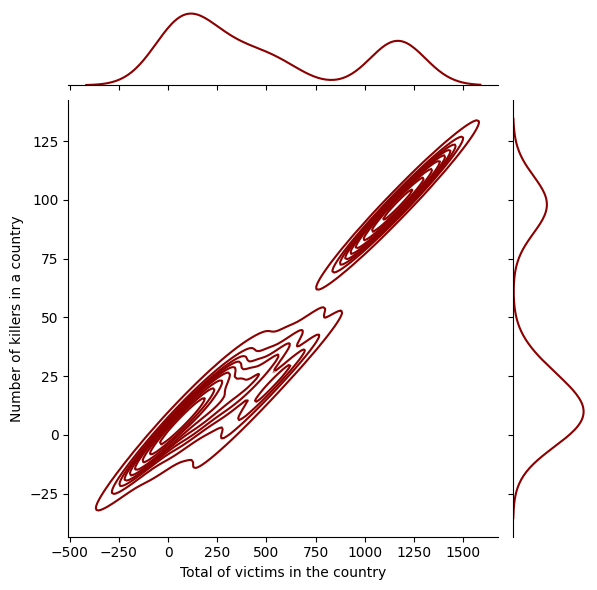

In [54]:
sns.jointplot(x=df['country victims'],
              y=df['amount'],
              kind="kde",
              color="darkred");
plt.axis('tight')
# plt.yticks([5,20,40,100])
# plt.xticks(range(40,1200,100))

# plt.title('Number of Killers in a Country and Total Victims in it')
plt.ylabel('Number of killers in a country')
plt.xlabel('Total of victims in the country')

In [ ]:
victimstats=df.groupby('country')['proven victims'].agg(['median','mean','max','min']).round(1).sort_values(by='median', ascending=False)
victimstats.reset_index(inplace=True)

+ Repetimos los histogramas, esta vez para estudiar el número de víctimas por país.

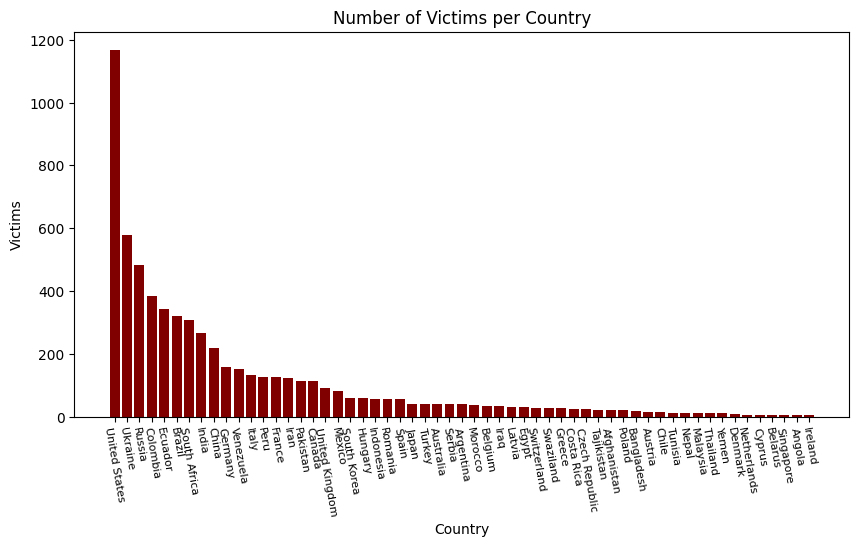

In [38]:
victimspercountry=df.groupby('country')['proven victims'].sum().sort_values(ascending=False).reset_index()
#HISTOGRAMA
plt.figure(figsize=(10,5));
plt.bar(victimspercountry['country'],height=victimspercountry['proven victims'],color='maroon')
plt.axis('tight');
plt.xticks(rotation=-80, fontsize=8);
plt.xlabel('Country');
plt.ylabel('Victims');
plt.title('Number of Victims per Country');

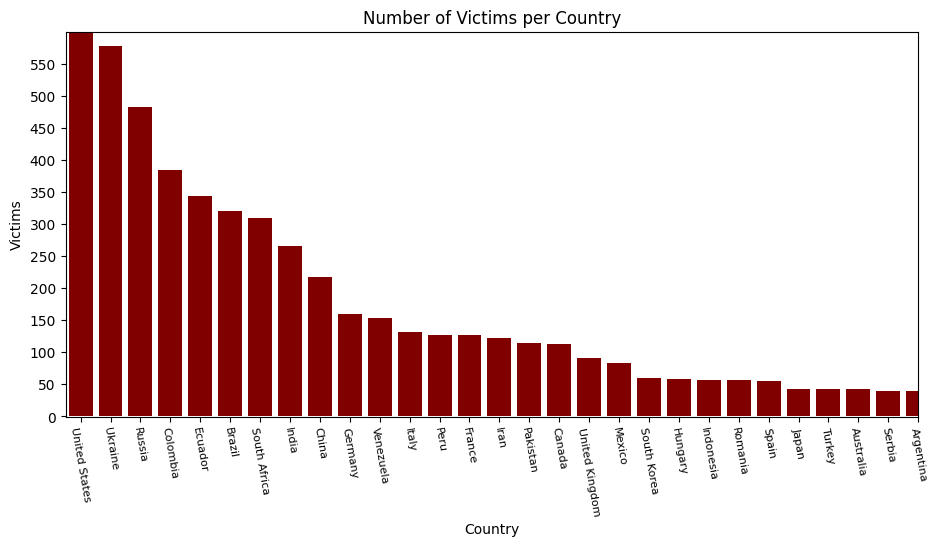

In [40]:
#zooming in
#HISTOGRAMA
plt.figure(figsize=(11,5));
plt.bar(victimspercountry['country'],height=victimspercountry['proven victims'],color='maroon')
plt.axis('tight');
plt.xticks(rotation=-80, fontsize=8);
plt.xlabel('Country');
plt.ylabel('Victims');
plt.title('Number of Victims per Country');
plt.xlim([-0.5,'Argentina'])
plt.ylim([-0.5,600]);
plt.yticks(range(0,600,50));
# plt.gca().invert_xaxis()
# ax[0]=invert_xaxis()

+ "Hacemos zoom" para descartar el outlier que es EE.UU.

### HIPOTESIS 2 y 3.
Densidad de población e índice de pobreza

In [19]:
killerspercountrypovrdens=df.groupby('country')[['density','pov rate','amount']].agg({'density':'first','pov rate':'first','amount':'first'}).round(2).sort_values(by='amount', ascending=False).reset_index()
killerspercountrypovrdens
#this shows the amount of killers per country related to its density and pov rate

,country,density,pov rate,amount
0,United States,34.56,0.17,98
1,Russia,9.00,NaN,27
2,Ukraine,78.52,NaN,26
3,South Africa,43.68,NaN,19
4,Germany,231.31,0.10,13
5,United Kingdom,264.94,0.12,13
6,France,120.59,0.08,12
7,India,421.14,NaN,11
8,China,144.58,NaN,10
9,Italy,203.41,0.14,9


In [ ]:
#Tomamos la densidad de Singapur como un outlier, ya que descompensa todas las medidas y scatterplots
df['country'][df['density'].idxmax()]

+ Se hace una matriz de correlación con todas las variables numéricas:

In [20]:
#correlation matrix (same for pov rate not null)
dfcorr=(df[['proven victims','pov rate','density','amount']][(df['pov rate'].notnull())&(df['density'].notnull()) ]).corr()
dfcorr

,proven victims,pov rate,density,amount
proven victims,1.000000,0.063087,-0.118119,-0.006500
pov rate,0.063087,1.000000,-0.555718,0.744970
density,-0.118119,-0.555718,1.000000,-0.622224
amount,-0.006500,0.744970,-0.622224,1.000000


Hay una clara correlación (0.75) entre el índice de pobreza y el número de asesinos en serie de un país, por lo que lo comprobaremos en un mapa de calor.

Text(0.5, 1.0, 'Serial killer demographic heatmap')

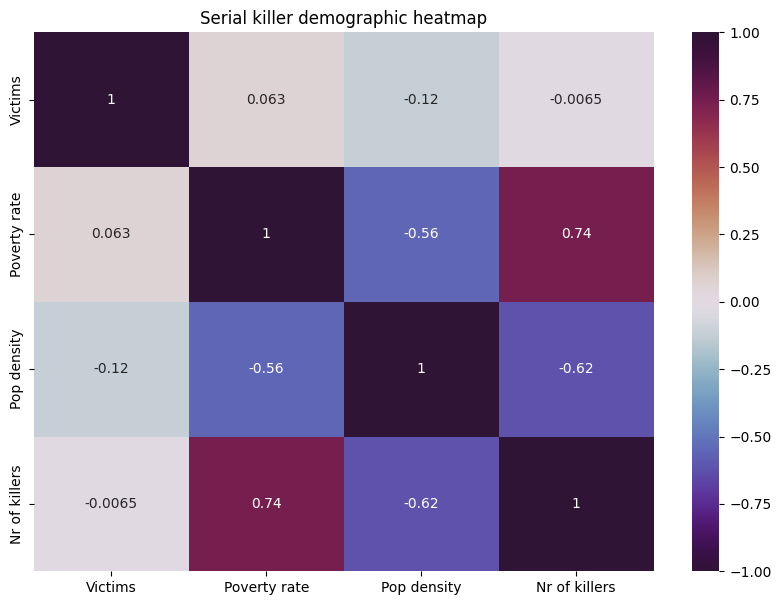

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(dfcorr,
            vmin=-1,
            vmax=1,
            cmap='twilight_shifted',
            square=False,
            annot=True,
            xticklabels=['Victims','Poverty rate','Pop density', 'Nr of killers'],
            yticklabels=['Victims','Poverty rate','Pop density', 'Nr of killers']
            );
plt.title('Serial killer demographic heatmap')


+ Parece que hay una correlación positiva entre el índice de pobreza y el número de asesinos de un país.

+ Por otra parte, hay una correlación negativa débil entre el la densidad y el número de asesinos (así como entre el índice de pobreza y la densidad, aunque eso no afecta al estudio).

El scatterplot no permite verlo con tanta claridad (aunque he recortado los límites para descartar outliers de densidad, como Singapur, y de víctimas, como Colombia):

+ Densidad frente a número de asesinos y de víctimas:

(0.0, 550.0)

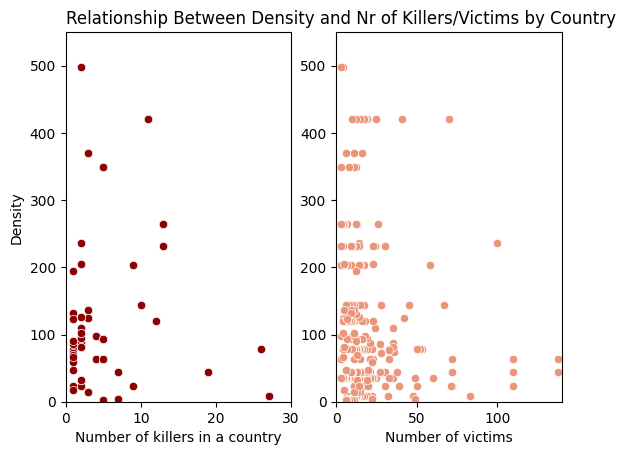

In [23]:
plt.subplot(1,2,1)
plt.title('Relationship Between Density and Nr of Killers/Victims by Country', loc='left')
sns.scatterplot(x='amount', y='density', data=df[df['density'].notnull()],color='darkred')
plt.xlim(0,30)
plt.ylim(0,550)
plt.xlabel('Number of killers in a country')
plt.ylabel('Density')

plt.subplot(1,2,2)
sns.scatterplot(x='proven victims', y='density', color='darksalmon',data=df[df['density'].notnull()])
plt.ylabel("")
plt.xlabel('Number of victims')
plt.xlim(0,140)
plt.ylim(0,550)
#left outliers out of the plot

+ Índice de pobreza frente a número de asesinos y de víctimas:

C:\Users\Agui\AppData\Local\Temp\ipykernel_14928\3481068206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scattpov.drop_duplicates('country',inplace=True)


(0.05, 0.225)

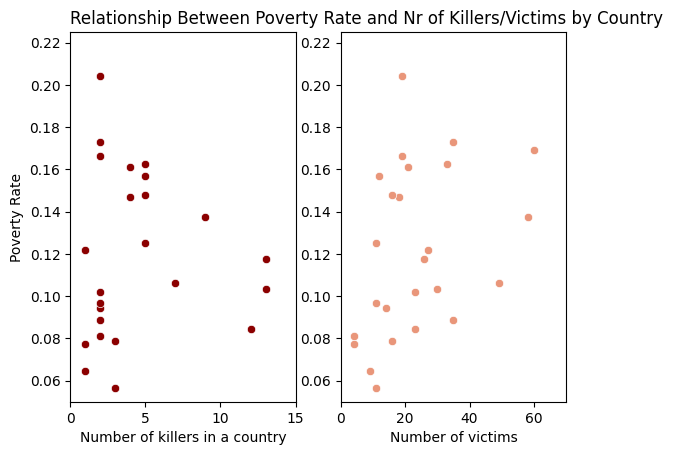

In [57]:
scattpov=df[df['pov rate'].notnull()]
scattpov.drop_duplicates('country',inplace=True)
plt.subplot(1,2,1)
plt.title('Relationship Between Poverty Rate and Nr of Killers/Victims by Country  ', loc='left')
sns.scatterplot(x='amount', y='pov rate', data=scattpov,color='darkred')
plt.xlim(0,15)
plt.ylim(0.05,0.225)
plt.xlabel('Number of killers in a country')
plt.ylabel('Poverty Rate')

plt.subplot(1,2,2)
sns.scatterplot(x='proven victims', y='pov rate', color='darksalmon',data=scattpov)
plt.xlabel('Number of victims')
plt.ylabel('')
plt.xlim(0,70)
plt.ylim(0.05,0.225)

Tomamos EE.UU. como un outlier en cuanto a número de asesinos por país, así que lo excluímos de la gráfica.

### HIPOTESIS 4.
¿Son más comunes en América y Europa?

In [ ]:
df['country'].mode()

In [ ]:
df['country'].value_counts(ascending=False)
#box plot with quartiles

Parece que hay unos cuantos países que predominan en cuanto al número de asesinos. Haré un pie chart que refleje los más frecuentes:

In [45]:
df['country'][df['amount']>18].unique()

array(['Russia', 'United States', 'Ukraine', 'South Africa'], dtype=object)

In [46]:
us=len(df[df['country']=='United States'])
sa=len(df[df['country']=='South Africa'])
ukr=len(df[df['country']=='Ukraine'])
ru=len(df[df['country']=='Russia'])
other=len(df)-(us+sa+ukr+ru)

piecountries=pd.DataFrame(data={'country': ['United States','South Africa','Ukraine','Russia','Other'],
      'amount':[us,sa,ukr,ru,other]})
len(piecountries) 


5

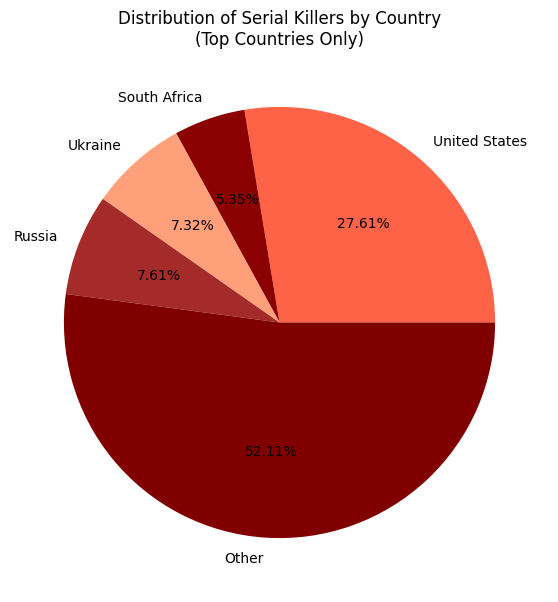

In [49]:
plt.figure(figsize=(7,7))
plt.pie((piecountries['amount']),
        labels=piecountries['country'],
        autopct='%1.2f%%',
        colors=['tomato','darkred','lightsalmon','brown','maroon'])

plt.title('Distribution of Serial Killers by Country\n(Top Countries Only)');

También podemos ver la comparación de todo el dataset en relación con EE.UU.:

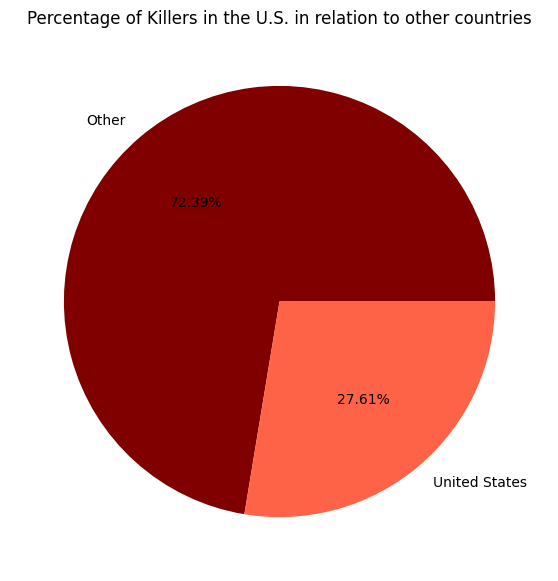

In [50]:
plt.figure(figsize=(7,7))
plt.pie((df['country']== 'United States').value_counts(),
        labels=['Other','United States'],
        autopct='%1.2f%%',
        colors=['maroon','tomato'])

plt.title('Percentage of Killers in the U.S. in relation to other countries');

En definitiva, EE.UU. tiene muchísimos más asesinos en serie a lo largo de los años.

Sin embargo, países como Rusia, Ucrania o Sudáfrica le pisan los talones, ya que entre todos sus asesinos componen cerca del 96% del dataset.

Por lo tanto, ante la pregunta de si los asesinos en serie son más frecuentes en EE.UU. y Europa, podemos decir que sí, en EE.UU. y en Europa del este y Asia occidental.

### HIPOTESIS 5.
¿Dónde los descubren o capturan antes?

In [ ]:
import squarify
plt.figure(figsize=(15,10))
squarify.plot(sizes=df.groupby('country')['proven victims'].max().sort_values(ascending=False).values, label=df.groupby('country')['proven victims'].max().sort_values(ascending=False).index, alpha=.8,color=['darkred','salmon','maroon','darksalmon','firebrick'])
plt.axis('off')
plt.title("Countries with the Highest Maximum Number of Proven Victims (Single Killer)")

# Conclusiones

Tras este análisis, se pueden sacar varias conclusiones de las hipótesis iniciales:

#### 1.Países en los que estos asesinos están más presentes o donde cometen más crímenes

Más de un cuarto de los asesinos en serie del *dataset* se encuentran en Estados Unidos, seguido de cerca por Rusia, Ucrania y Sudáfrica. Esto puede estar relacionado con la mayor cantidad de estudios y recursos dedicados a la criminología en Estados Unidos desde sus comienzos por parte del FBI. Sin embargo, también se observaron casos notables en países con menos visibilidad, como Colombia, en los que el número de asesinos era mucho menor pero el de víctimas era descomunal.
La disparidad en el número de víctimas por asesino entre diferentes países sugiere que en algunos lugares se da más visibilidad y se publican más datos sobre estos casos que en otros, lo que podría explicar la diferencia en la visibilidad de los asesinos en serie.
#### 2. Clase Socioeconómica

Se encontró una correlación significativa (0.74) entre el número de asesinos en serie y el índice de pobreza. Aunque esta correlación es prometedora, es cierto que había muchos valores nulos respecto a esta variable y que esa medida solamente no basta para determinar la clase social de cada asesino en concreto. Sin embargo, el país mas pobre de mi *dataset* era Ecuador y coincide con el dato de las 140 víctimas por un solo asesino (Luis Garavito), ya que este actuó tanto en Colombia, como en Venezuela y Ecuador. Sería interesante, a partir de esta correlación preliminar, considerar otras varibles para llegar a comprender completamente la relación entre clases socioeconómicas y asesinos en serie.
#### 3. Densidad de Población:

Aunque se observó una correlación negativa (-0.62) entre la densidad de población y el número de asesinos en serie, estos datos son poco concluyentes y su causalidad es cuestionable. Se requiere un análisis más exhaustivo que tenga en cuenta la densidad de población en los núcleos urbanos concretos donde opera cada asesino en serie.
Igualmente, serviría como punto de partida para otro posible análisis, dado que los datos indican que puede haber un nexo de la facilidad de que surja un asesino en serie en zonas poco pobladas.
#### 4.Predominancia de EE.UU. y Europa:

La mayoría de los asesinos en serie en el conjunto de datos provienen de EE.UU. y Europa del Este, lo que puede reflejar una mayor visibilidad y estudio de estos casos en estas regiones. Esto podría atribuirse a la presencia de organismos gubernamentales y recursos para investigar y rastrear este perfil de asesino.
#### 5.Captura de Asesinos:

La tasa de víctimas por asesino varía significativamente entre países. Los países con una alta tasa de víctimas por asesino, como Colombia, sugieren que los asesinos pueden no ser capturados con la misma rapidez debido a la falta de recursos o formación en perfiles psicológicos.

En resumen, este análisis exploratorio de datos sobre asesinos en serie revela tendencias interesantes, pero también destaca la necesidad de investigaciones más detalladas y contextualizadas de cada caso para comprender completamente los factores que subyacen tras de la presencia y el comportamiento de los asesinos en serie en diferentes países.

## Consideraciones para el futuro
+ Hay datos del *dataframe* que no he explotado en el análisis. Aun así, he decidido no borrarlos porque podría profundizarse en ellos en un segundo estudio. Si bien he podido comprobar mis hipótesis con las variables utilizadas, se podrían sacar muchas otras de los datos aún por explotar:

+ Por ejemplo, se podría limpiar la columna de *years active* para determinar patrones de actividad por país o por número de víctimas.
+ Se podría tratar de diferenciar a los asesinos según si son hombres o mujeres, para ver si cambia algún dato demográfico según este factor.
+ También se podría hacer una búsqueda de *keywords* de la columna *notes* para buscar patrones en su *modus operandi*.
+ Por último, se podría dividir a los asesinos por continente para obtener una visión más global de la distribución.

![img](utils/hannibal.png)